# Analyze Selected Queries

In [9]:
import json
import pandas as pd
import seaborn as sns

DATA_DIR = '/mnt/ceph/storage/data-in-progress/data-research/web-search/private-web-search-with-keyqueries/'
QUERY_DIR = DATA_DIR + 'scrambling-on-anserini/'

SCRAMBLING_APPROACHES = ['nounphrase','tf-idf', 'hbc', 'arampatzis', 'HbcTfIdf', 'arampatzisHbc']
RETRIEVAL_MODELS = ['bm25', 'qld']
SELECTION_STRATEGIES = ['ndcg', 'pmi']

TOPICS = [2, 8, 11, 17, 18, 26, 30, 33, 38, 40, 46, 47, 50, 57, 59, 61, 62, 66, 67, 78, 82, 88, 89, 95, 98, 104, 105, 109, 111, 117, 119, 121, 123, 128, 131, 136, 140, 142, 147, 152, 156, 162, 168, 173, 175, 177, 182, 196, 199, 207, 213, 222, 236, 253, 254, 262, 266, 273, 286, 287, 209, 214]

# Check that all selections are executed

In [2]:
for scr in SCRAMBLING_APPROACHES:
    for rtr in RETRIEVAL_MODELS:
        for stn in SELECTION_STRATEGIES:
            for topic in TOPICS:
                p = DATA_DIR + '/selected-scrambled-queries/'+ scr + "-" + rtr + "-" + stn + '/' + str(topic) + '.jsonl'
                try:
                    json.load(open(p))
                except:
                    print('Missing: ' + p.split('/selected-scrambled-queries/')[1])
                    break


# Load Relevant Documents per Topic

In [4]:
!pip install trectools

In [5]:
from trectools import TrecQrel
from tqdm import tqdm

topic_to_relevant_docs = {}

for qrel_file in ['qrels.web.1-50.txt', 'qrels.web.51-100.txt', 'qrels.web.101-150.txt',  'qrels.web.151-200.txt', 'qrels.web.201-250.txt', 'qrels.web.251-300.txt']:
        df_qrel = TrecQrel('../resources/topics-and-qrels/' + qrel_file).qrels_data
        for topic in tqdm(df_qrel['query'].unique()):
            topic_to_relevant_docs[topic] = set(df_qrel[(df_qrel['query'] == topic) & (df_qrel['rel'] > 0)]['docid'].unique())


100%|██████████| 50/50 [00:00<00:00, 668.43it/s]


In [7]:
import pandas as pd

def load_docs_in_topic(approach, topic, stop_at_position=1000, num_queries=1000):
    import json
    #print(DATA_DIR + 'submitted-scrambled-queries/' + approach + '/' + str(topic) + '.jsonl')
    topic_data = json.load(open(DATA_DIR + 'submitted-scrambled-queries/' + approach + '/' + str(topic) + '.jsonl'))
    ret = []
    for q, v in topic_data.items():
        if int(q) <= num_queries:
            ret += v['ranking'][:stop_at_position]
    
    return set(ret)

def evaluate_approach(approach_file_name, scramblingApproach, scramblingRetrievalModel, querySelection):
    ret = []
    for topic in TOPICS:
        if topic == 95:
            # no judged docs for 95
            continue
        
        rel = topic_to_relevant_docs[topic]
        for top_docs in [10, 100]:
            for num_queries in [5, 10, 25]:
                retrieved = load_docs_in_topic(approach_file_name, topic, top_docs, num_queries if scramblingApproach.lower() != 'orig' else 1000)
                relevant_doc_count = 0
                for r in retrieved:
                    if r in rel:
                        relevant_doc_count += 1
                
                ret += [{
                    'Scrambling Approach': scramblingApproach,
                    'topic': topic,
                    'docs_retrieved': top_docs,
                    'relevant_docs_retrieved': relevant_doc_count,
                    'relevant_docs_in_topic': len(rel),
                    'num_queries': num_queries,
                    'Scrambling Retrieval Model': scramblingRetrievalModel,
                    'Selection of Queries': querySelection
                }]
    return ret
df = []

for rtr in RETRIEVAL_MODELS:
    for stn in SELECTION_STRATEGIES:
        #df += evaluate_approach('orig', 'Orig', rtr, stn)
        for scr in SCRAMBLING_APPROACHES:
            df += evaluate_approach(scr + '-' + rtr + '-' + stn, scr, rtr, stn)

df = pd.DataFrame(df)
df['Recall'] = df['relevant_docs_retrieved']/df['relevant_docs_in_topic']

# In Progress...

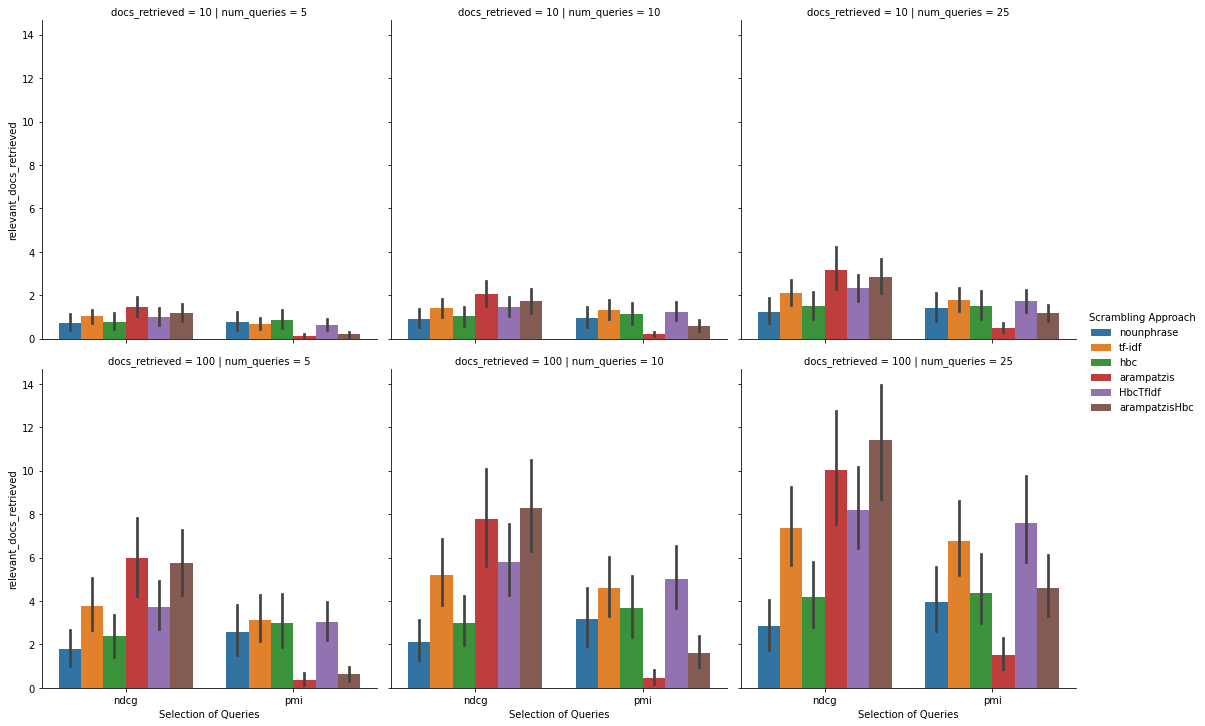

In [10]:
sns.catplot(data=df[df['Scrambling Approach'] != 'Orig'],  x='Selection of Queries', y='relevant_docs_retrieved', col='num_queries', hue='Scrambling Approach', row='docs_retrieved', kind='bar')

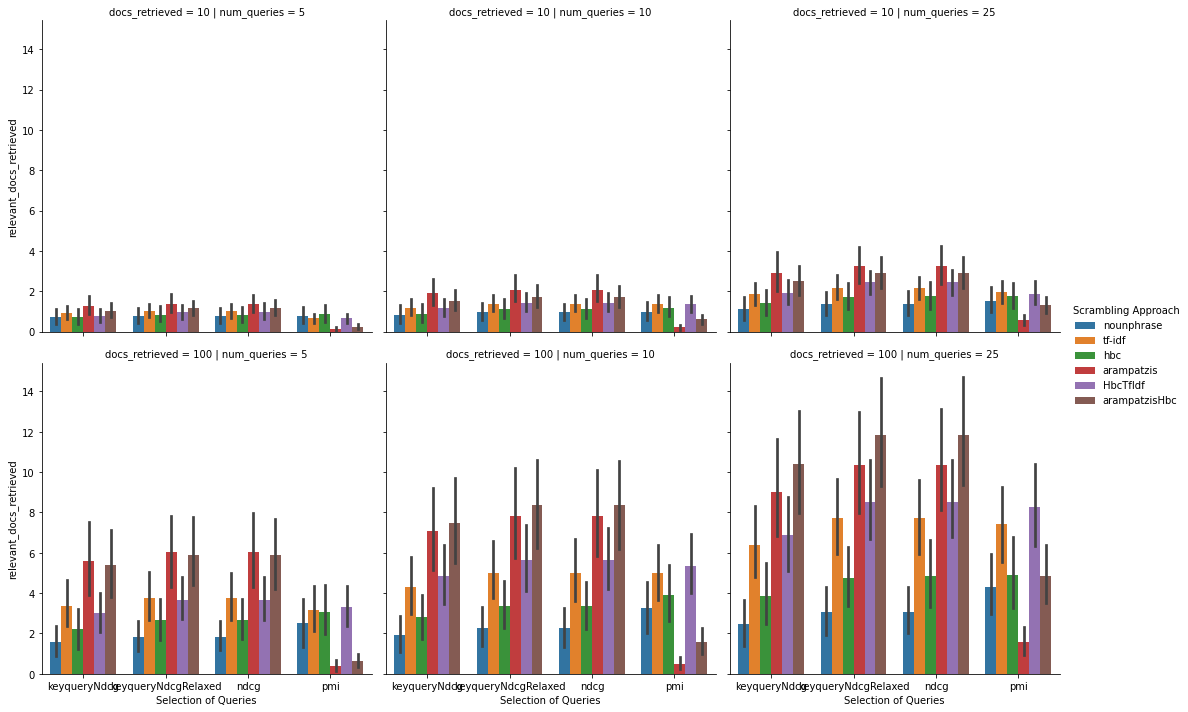

In [163]:
sns.catplot(data=df[df['Scrambling Approach'] != 'Orig'],  x='Selection of Queries', y='relevant_docs_retrieved', col='num_queries', hue='Scrambling Approach', row='docs_retrieved', kind='bar')

# Compare Different Query Selection Strategies

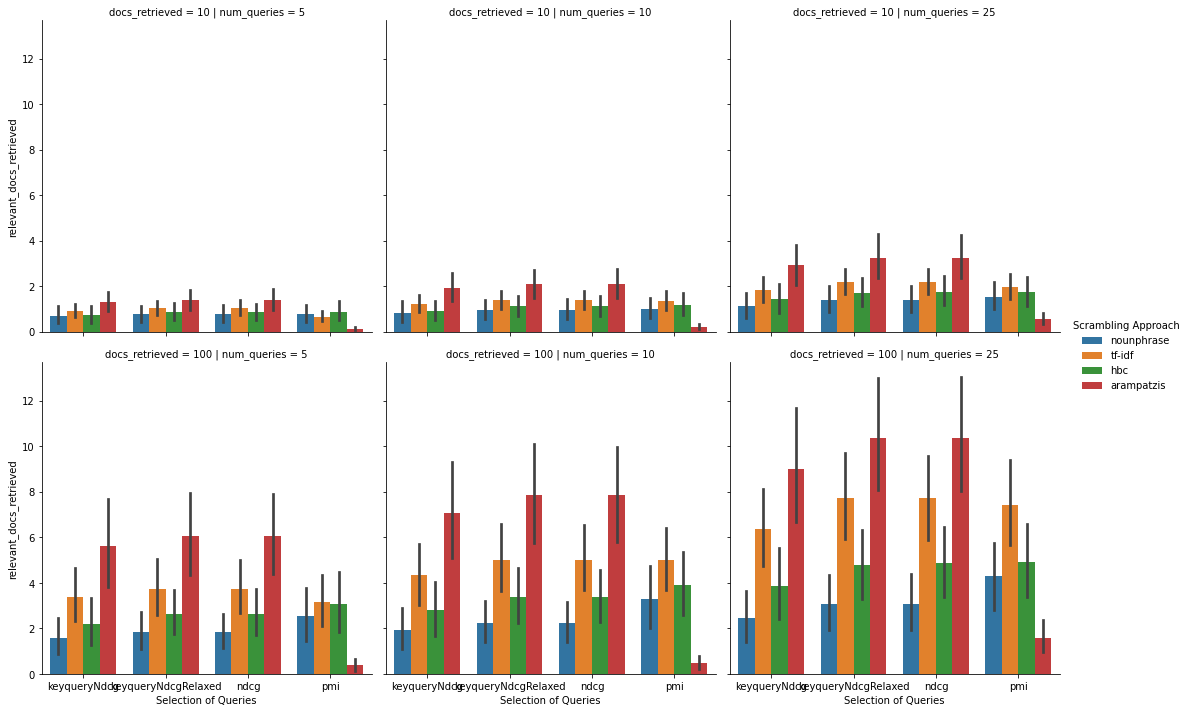

In [152]:
sns.catplot(data=df[df['Scrambling Approach'] != 'Orig'],  x='Selection of Queries', y='relevant_docs_retrieved', col='num_queries', hue='Scrambling Approach', row='docs_retrieved', kind='bar')

In [18]:
df_tmp_save = pd.DataFrame(df.groupby(['Selection of Queries','docs_retrieved', 'Scrambling Approach', 'Scrambling Retrieval Model', 'num_queries'])['relevant_docs_retrieved'].mean()).reset_index().sort_values('relevant_docs_retrieved', ascending=False)
df_tmp_save.to_json('/mnt/ceph/storage/data-in-progress/data-research/web-search/private-web-search-with-keyqueries/scrambling-on-anserini/recall-for-topics.jsonl', orient='records')
df_tmp_save

,Selection of Queries,docs_retrieved,Scrambling Approach,Scrambling Retrieval Model,num_queries,relevant_docs_retrieved
50,ndcg,100,arampatzisHbc,bm25,25,11.852459
53,ndcg,100,arampatzisHbc,qld,25,10.967213
44,ndcg,100,arampatzis,bm25,25,10.704918
47,ndcg,100,arampatzis,qld,25,9.393443
49,ndcg,100,arampatzisHbc,bm25,10,8.688525
...,...,...,...,...,...,...
84,pmi,10,arampatzisHbc,bm25,5,0.196721
87,pmi,10,arampatzisHbc,qld,5,0.196721
82,pmi,10,arampatzis,qld,10,0.180328
78,pmi,10,arampatzis,bm25,5,0.147541


In [135]:
pd.DataFrame(df.groupby(['Selection of Queries','docs_retrieved', 'num_queries'])['relevant_docs_retrieved'].mean()).reset_index().sort_values('relevant_docs_retrieved', ascending=False)

,Selection of Queries,docs_retrieved,num_queries,relevant_docs_retrieved
17,ndcg,100,25,8.250820
11,keyqueryNdcgRelaxed,100,25,8.229508
5,keyqueryNdcg,100,25,7.391803
10,keyqueryNdcgRelaxed,100,10,6.737705
16,ndcg,100,10,6.737705
4,keyqueryNdcg,100,10,6.265574
15,ndcg,100,5,5.908197
9,keyqueryNdcgRelaxed,100,5,5.908197
3,keyqueryNdcg,100,5,5.604918
14,ndcg,10,25,2.391803


# Identified relevant Documents for Selection strategy ndcg (Best)

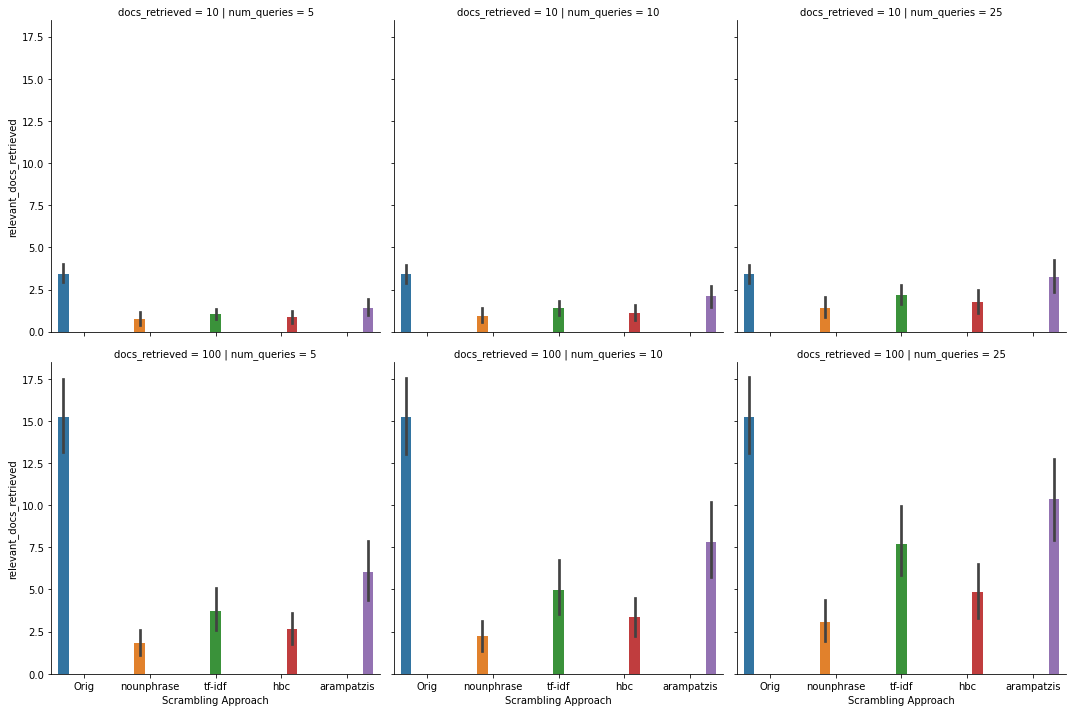

In [141]:
sns.catplot(data=df[df['Selection of Queries'] == 'ndcg'], x='Scrambling Approach', y='relevant_docs_retrieved', col='num_queries', hue='Scrambling Approach', row='docs_retrieved', kind='bar')

# Identified relevant Documents for Selection strategy keyqueryNdcgRelaxed

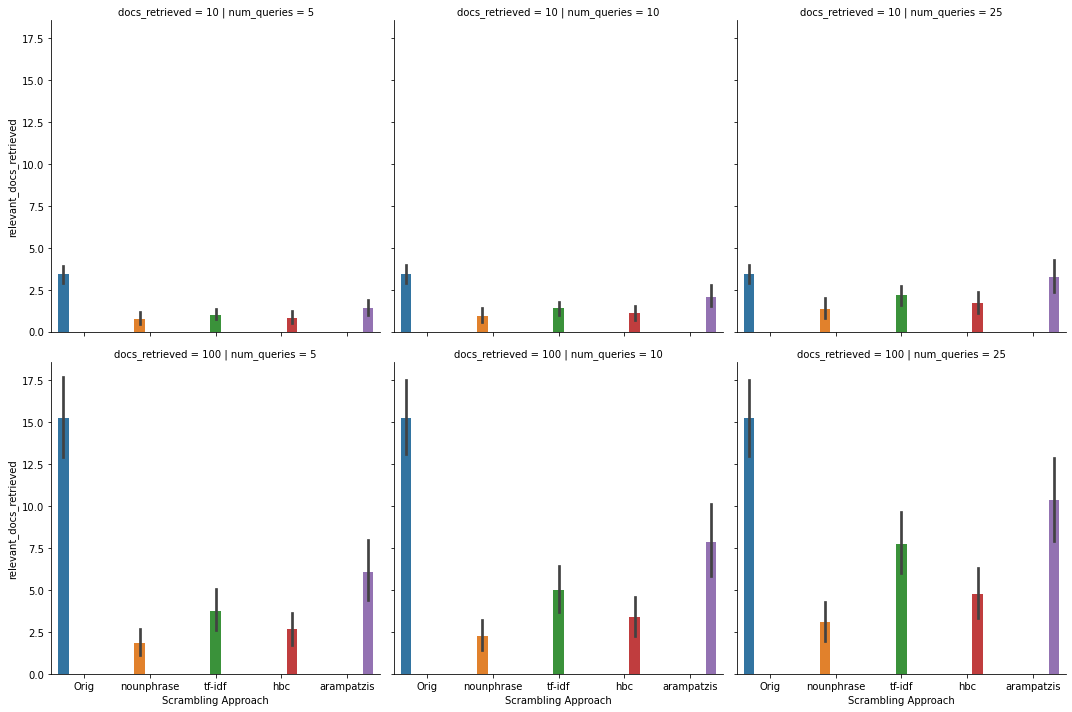

In [143]:
sns.catplot(data=df[df['Selection of Queries'] == 'keyqueryNdcgRelaxed'], x='Scrambling Approach', y='relevant_docs_retrieved', col='num_queries', hue='Scrambling Approach', row='docs_retrieved', kind='bar')

# Identified relevant Documents for Selection strategy keyqueryNdcg

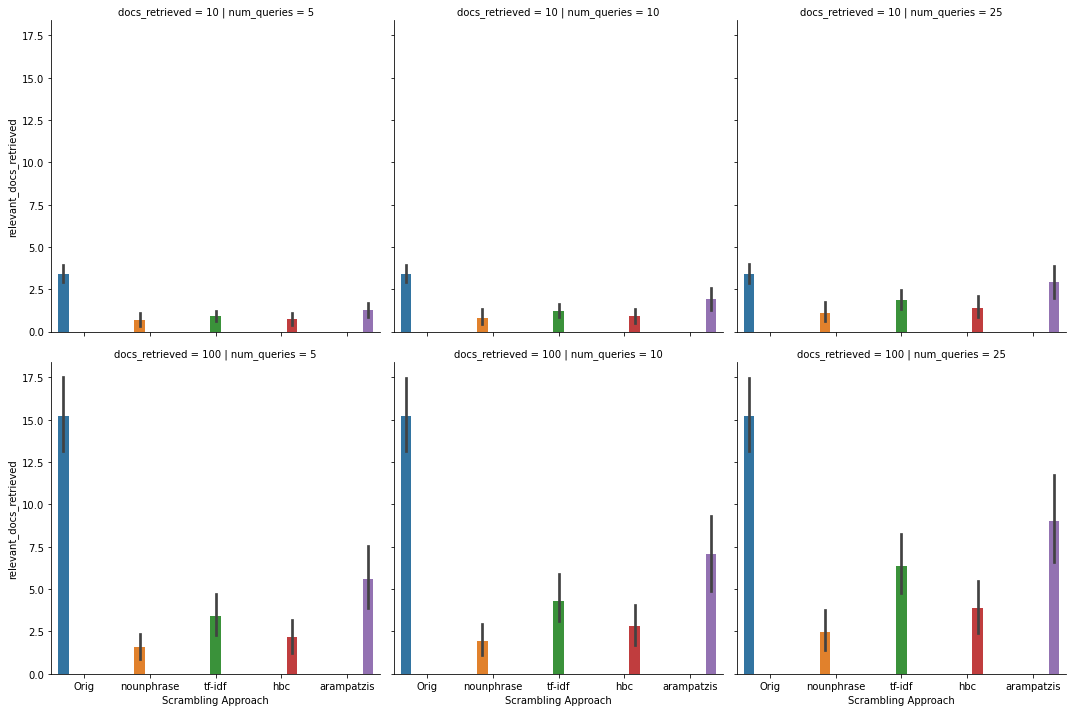

In [144]:
sns.catplot(data=df[df['Selection of Queries'] == 'keyqueryNdcg'], x='Scrambling Approach', y='relevant_docs_retrieved', col='num_queries', hue='Scrambling Approach', row='docs_retrieved', kind='bar')